In [2]:
#RUN FIRST

curr_dir = f'/user_data/csimmon2/git_repos/ptoc'

import sys
sys.path.insert(0,curr_dir)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy.stats as stats
import scipy
import statsmodels.api as s
from sklearn import metrics

import pdb
import ptoc_params as params

from plotnine import *

#hide warnings
import warnings
warnings.filterwarnings('ignore')

#load additional libraries
from nilearn import image, plotting, input_data, glm
from nilearn.input_data import NiftiMasker
import nibabel as nib
import statsmodels.api as sm
from nilearn.datasets import load_mni152_brain_mask, load_mni152_template
from nilearn.glm.first_level import compute_regressor 

suf = params.suf
#mni = load_mni152_brain_mask()



'''exp info'''
#load subject info
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()

study = 'ToolLoc'
study_dir = "/user_data/csimmon2/temp_derivatives"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
exp = ''
#control_tasks = ['loc']
file_suf = ''

data_dir = params.data_dir
fig_dir = params.fig_dir
task_info = params.task_info
raw_dir = params.raw_dir

'''scan params'''
tr = 1 #toolloc_params
vols = 341 #toolloc_params

whole_brain_mask = load_mni152_brain_mask()
mni = load_mni152_template()
brain_masker = NiftiMasker(whole_brain_mask, smoothing_fwhm=0, standardize=True)

Successfully saved group average for pIPS left fc
Successfully saved group average for pIPS left ppi
Successfully saved group average for pIPS right fc
Successfully saved group average for pIPS right ppi
Successfully saved group average for aIPS left fc
Successfully saved group average for aIPS left ppi
Successfully saved group average for aIPS right fc
Successfully saved group average for aIPS right ppi
Successfully saved group average for LO left fc
Successfully saved group average for LO left ppi
Successfully saved group average for LO right fc
Successfully saved group average for LO right ppi


/tmp/ipykernel_4091/1000254059.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


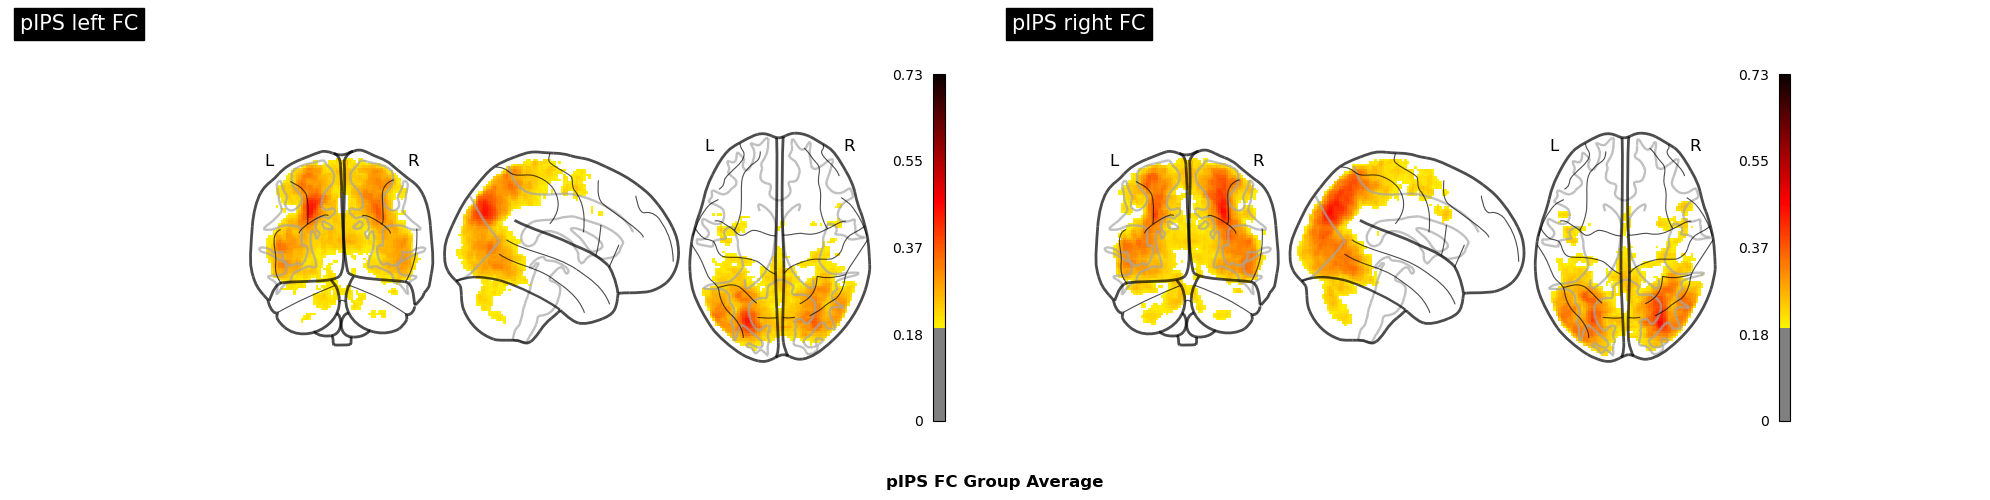

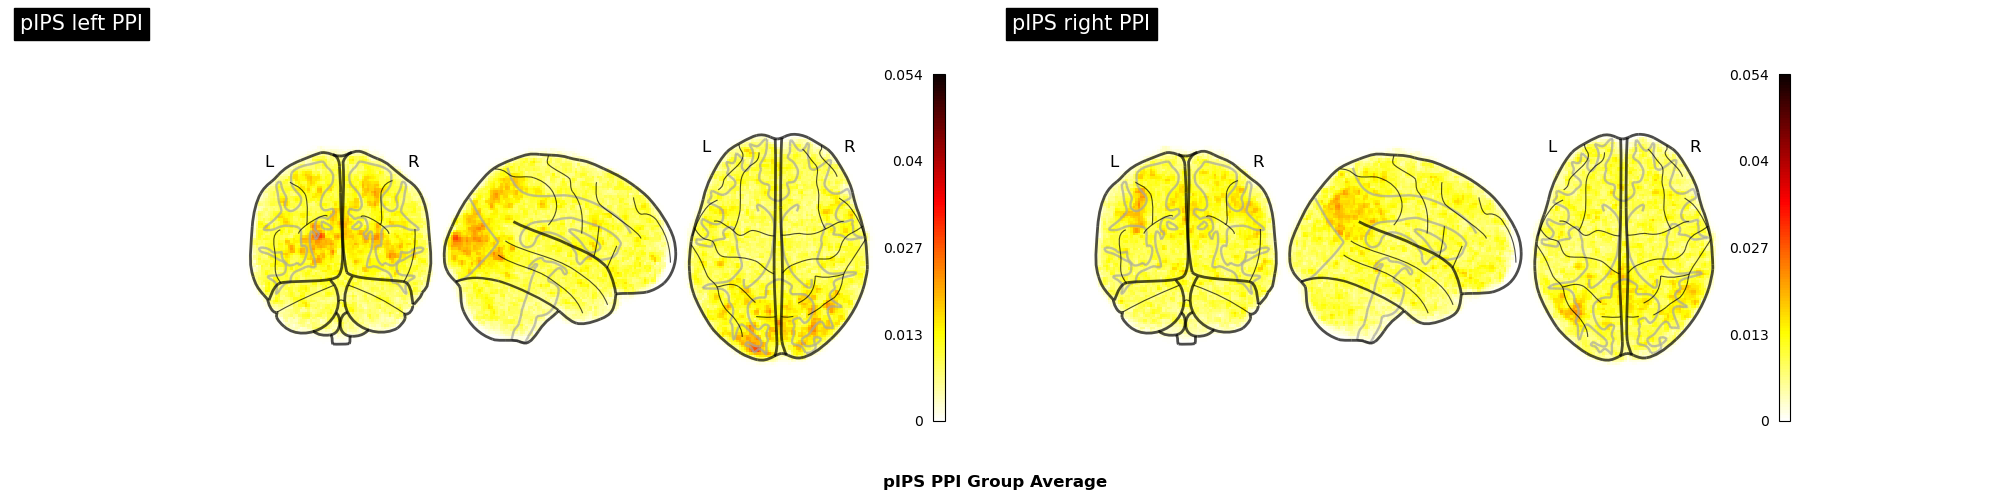

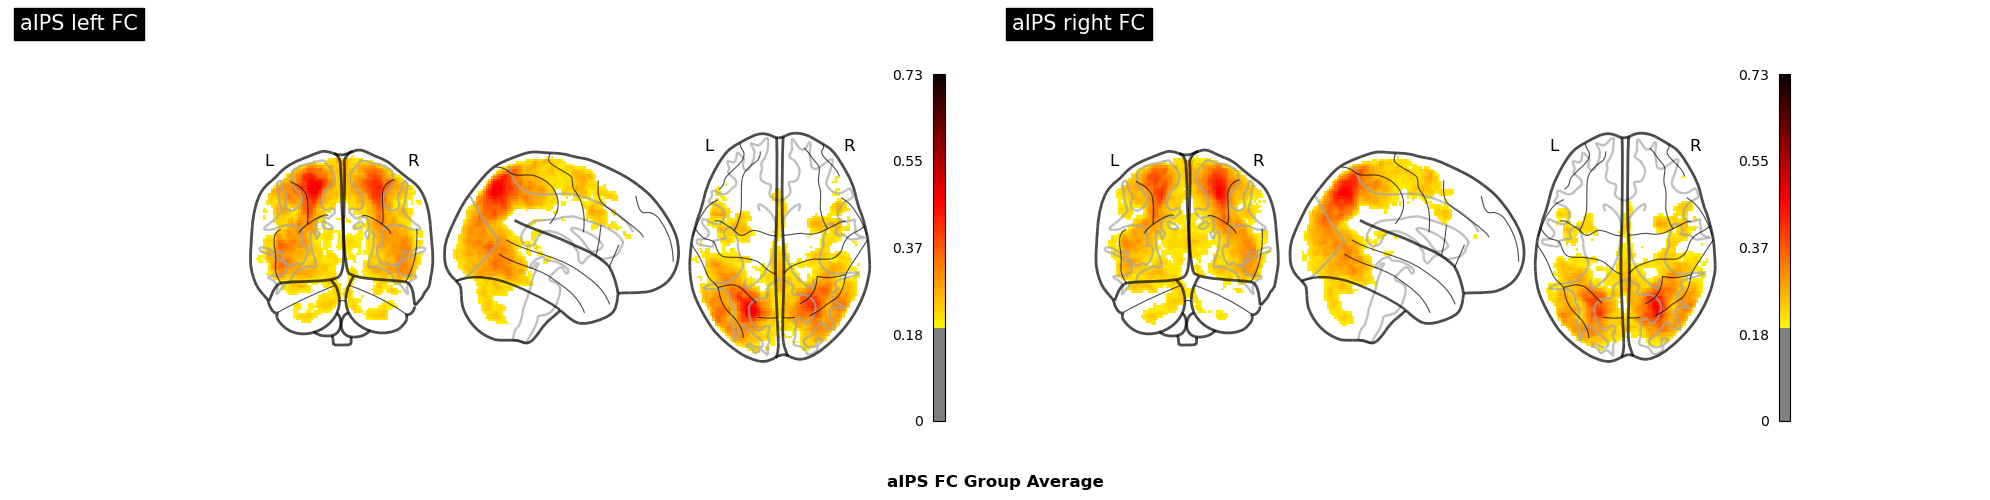

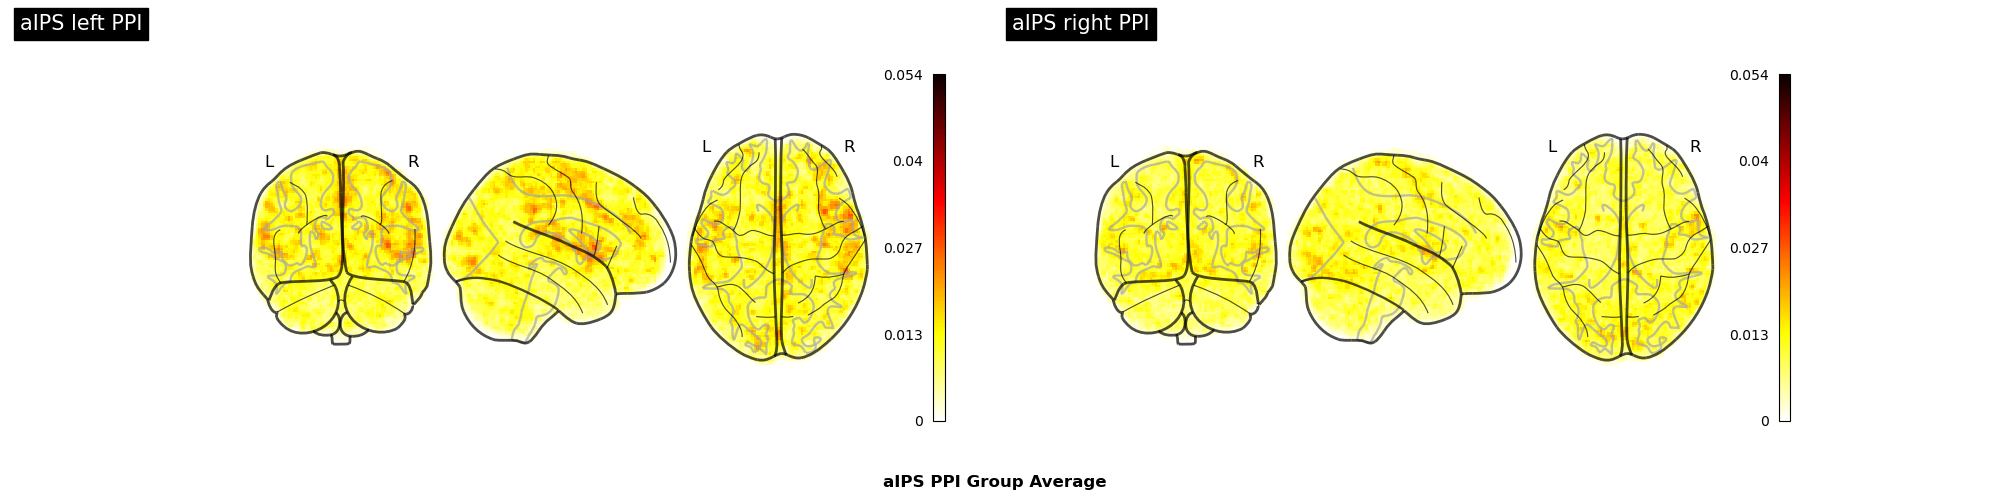

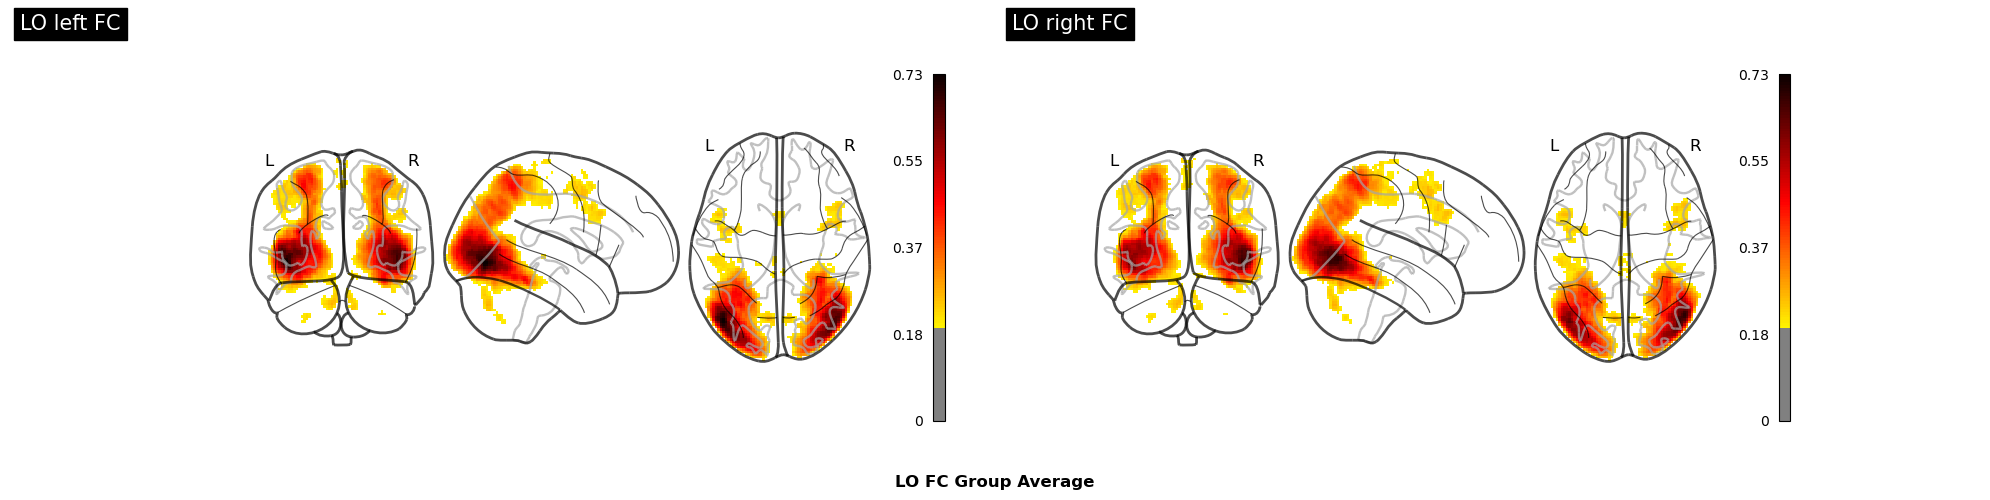

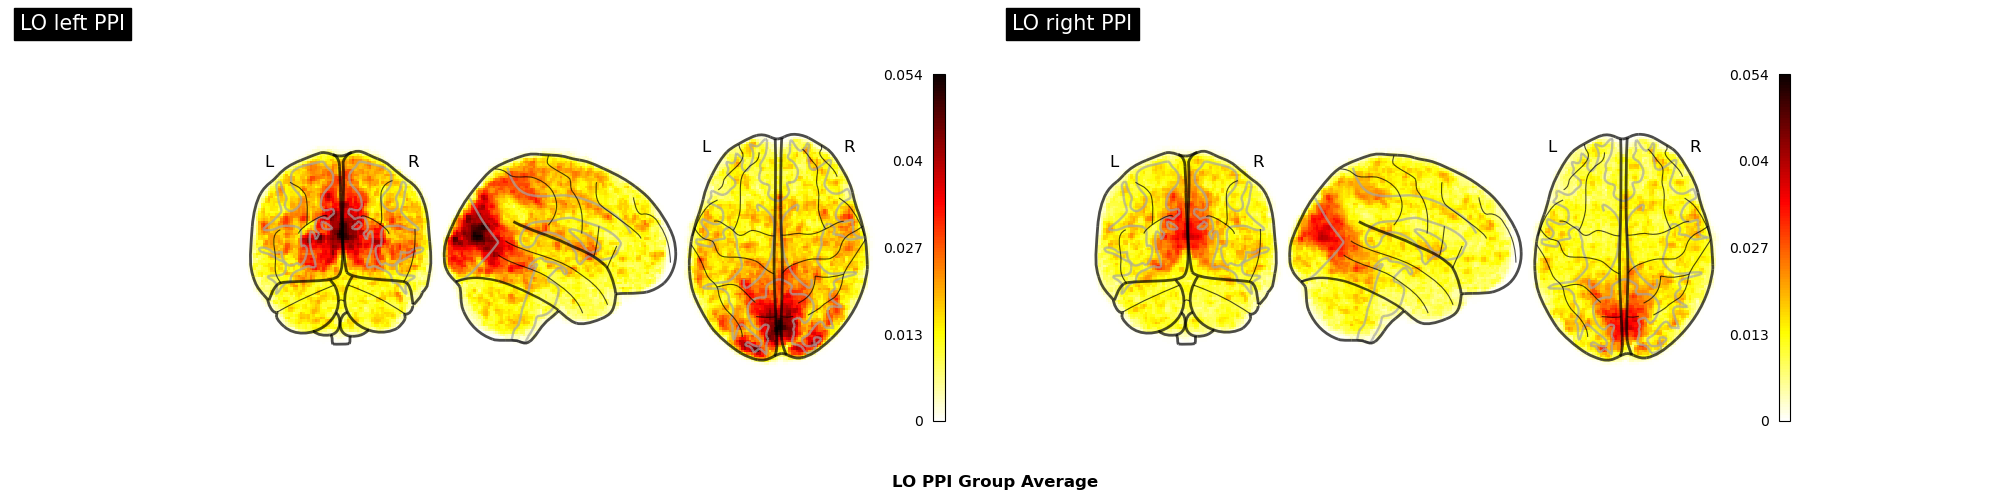

In [5]:
# group average with hemisphere and tool
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting
import matplotlib.pyplot as plt

# Define study directories
study_dir = "/lab_data/behrmannlab/vlad/ptoc"  # Updated to match registration script
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/tools'
curr_dir = '/user_data/csimmon2/git_repos/ptoc'

# Explicitly set the path to sub_info.csv
sub_info_path = f'{curr_dir}/sub_info_tool.csv'

# Define subjects and ROIs
sub_info = pd.read_csv(sub_info_path)
subs = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()
rois = ['pIPS', 'aIPS', 'LO']  # Updated to match registration script
hemispheres = ['left', 'right']

def create_group_averages(subs, rois, hemispheres, out_dir):
    for roi in rois:
        for hemi in hemispheres:
            for analysis_type in ['fc', 'ppi']:
                all_sub_imgs = []
                for sub in subs:
                    # Updated path to match registration script's MNI output directory
                    mni_dir = f"{study_dir}/{sub}/ses-01/derivatives/{analysis_type}/mni"
                    img_file = f"{mni_dir}/{sub}_{roi}_{hemi}_ToolLoc_{analysis_type}_mni.nii.gz"
                    
                    if os.path.exists(img_file):
                        all_sub_imgs.append(image.load_img(img_file))
                    else:
                        print(f"Warning: File not found for {sub}, {roi}, {hemi}, {analysis_type}")
                
                if all_sub_imgs:
                    # Create and save average image if files were found
                    avg_img = image.mean_img(all_sub_imgs)
                    out_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                    nib.save(avg_img, out_file)
                    print(f"Successfully saved group average for {roi} {hemi} {analysis_type}")
                else:
                    print(f"No images found for {roi} {hemi} {analysis_type}")

def plot_group_averages(out_dir, rois, hemispheres):
    # Calculate separate max values for FC and PPI
    fc_max = 0
    ppi_max = 0
    
    # Find maximum values across all ROIs and hemispheres
    for roi in rois:
        for hemi in hemispheres:
            # Get FC max
            img_file = f'{out_dir}/{roi}_{hemi}_fc_avg.nii.gz'
            if os.path.exists(img_file):
                data = nib.load(img_file).get_fdata()
                fc_max = max(fc_max, np.abs(data).max())
            
            # Get PPI max
            img_file = f'{out_dir}/{roi}_{hemi}_ppi_avg.nii.gz'
            if os.path.exists(img_file):
                data = nib.load(img_file).get_fdata()
                ppi_max = max(ppi_max, np.abs(data).max())

    # Create plots for each ROI
    for roi in rois:
        for analysis_type in ['fc', 'ppi']:
            fig, axes = plt.subplots(1, 2, figsize=(20, 5))
            
            # Set max value and threshold based on analysis type
            if analysis_type == 'fc':
                vmax = fc_max
                threshold = 0.2
            else:
                vmax = ppi_max
                threshold = 0 #0.012
            
            for i, hemi in enumerate(hemispheres):
                img_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                if os.path.exists(img_file):
                    display = plotting.plot_glass_brain(
                        img_file, 
                        threshold=threshold,
                        colorbar=True,
                        vmax=vmax, 
                        vmin=-vmax,
                        title=f'{roi} {hemi} {analysis_type.upper()}',
                        axes=axes[i],
                        display_mode='ortho'
                    )
            
            plt.tight_layout()
            fig.text(0.5, 0.01, f'{roi} {analysis_type.upper()} Group Average', 
                     ha='center', va='bottom', fontsize=12, fontweight='bold')
            plt.subplots_adjust(bottom=0.15)
            #plt.savefig(f'{out_dir}/{roi}_{analysis_type}_group_average.png', dpi=300, bbox_inches='tight')
            #plt.close()

def main():
    # Create output directory for group averages
    group_out_dir = f'{results_dir}/group_averages'
    os.makedirs(group_out_dir, exist_ok=True)

    # Create group averages
    #create_group_averages(subs, rois, hemispheres, group_out_dir)

    # Plot group averages
    plot_group_averages(group_out_dir, rois, hemispheres)

if __name__ == "__main__":
    main()

In [19]:
# Extract PPI results for pIPS to LO connectivity in native space - this uses the 6 mm sphere ROIs
import os
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn.input_data import NiftiSpheresMasker
from nilearn import image
import sys
import time

# Import parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ToolLoc'
study_dir = "/user_data/csimmon2/temp_derivatives"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/tools'
raw_dir = params.raw_dir

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info_tool.csv')
subjects = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()

hemispheres = ['left', 'right']
analysis = 'ppi'
task = 'ToolLoc'
condition = 'tools'  # Explicitly using tools condition
seed_regions = ['pIPS', 'aIPS']  # Added aIPS as a seed region

def create_roi_masker(coords):
    return NiftiSpheresMasker([tuple(coords)], radius=6)

def extract_mean_activation(results_img, roi_masker):
    roi_data = roi_masker.fit_transform(results_img)
    return np.mean(roi_data)

def get_roi_coordinates(roi_coords, subject, hemisphere, roi_base, condition):
    hemi_prefix = 'l' if hemisphere == 'left' else 'r'
    roi_name = f"{hemi_prefix}{roi_base}"
    
    curr_coords = roi_coords[
        (roi_coords['subject'] == subject) &
        (roi_coords['task'] == task) &
        (roi_coords['condition'] == condition) &
        (roi_coords['roi'] == roi_name)
    ]
    
    if curr_coords.empty:
        return None
    return curr_coords[['x', 'y', 'z']].values.tolist()[0]

def process_subjects():
    results = []
    
    # Load centralized ROI coordinates
    roi_coords = pd.read_csv('/user_data/csimmon2/git_repos/ptoc/tools/roi_coordinates.csv')
    
    for subject in subjects:
        print(f"Processing subject: {subject}")
        
        # First, get LO target coordinates for both hemispheres
        lo_maskers = {}
        for target_hemisphere in hemispheres:
            lo_coords = get_roi_coordinates(roi_coords, subject, target_hemisphere, 'LO', condition)
            
            if lo_coords is None:
                print(f"No LO coordinates found for {subject}, {target_hemisphere}, {condition}")
                continue
                
            lo_maskers[target_hemisphere] = create_roi_masker(lo_coords)
        
        # Now process both pIPS and aIPS seeds
        for seed_region in seed_regions:
            for seed_hemisphere in hemispheres:
                # Using native space images
                seed_file = f"{subject}_{seed_region}_{seed_hemisphere}_{task}_{analysis}.nii.gz"
                full_seed_path = os.path.join(study_dir, f"{subject}", 'ses-01', 'derivatives', 'fc', seed_file)
                
                if not os.path.exists(full_seed_path):
                    print(f"No PPI results file found for {subject}, {seed_region}, {seed_hemisphere}")
                    continue
                
                try:
                    seed_img = nib.load(full_seed_path)
                except Exception as e:
                    print(f"Error loading seed image for {subject}, {seed_region}, {seed_hemisphere}: {e}")
                    continue
                
                # Extract connectivity with each LO target
                for target_hemisphere, lo_masker in lo_maskers.items():
                    try:
                        mean_activation = extract_mean_activation(seed_img, lo_masker)
                        
                        results.append({
                            'subject': subject,
                            'seed_roi': seed_region,
                            'seed_hemisphere': seed_hemisphere,
                            'target_roi': 'LO',
                            'target_hemisphere': target_hemisphere,
                            'task': task,
                            'analysis': analysis,
                            'mean_activation': mean_activation
                        })
                    except Exception as e:
                        print(f"Error extracting activation for {subject}, {target_hemisphere} LO: {e}")
                        continue
    
    # Create DataFrame and save results
    results_df = pd.DataFrame(results)
    output_file = os.path.join(results_dir, 'seed_target_activations.csv')
    results_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

if __name__ == "__main__":
    process_subjects()

Processing subject: sub-spaceloc1001
Processing subject: sub-spaceloc1002
Processing subject: sub-spaceloc1003
Processing subject: sub-spaceloc1004
Processing subject: sub-spaceloc1005
Processing subject: sub-spaceloc1006
Processing subject: sub-spaceloc1007
Processing subject: sub-spaceloc1008
Processing subject: sub-spaceloc1009
Processing subject: sub-spaceloc1010
Processing subject: sub-spaceloc1011
Processing subject: sub-spaceloc1012
Processing subject: sub-spaceloc2013
Processing subject: sub-spaceloc2014
Processing subject: sub-spaceloc2015
Processing subject: sub-spaceloc2016
Processing subject: sub-spaceloc2017
Processing subject: sub-spaceloc2018
Results saved to /user_data/csimmon2/git_repos/ptoc/results/tools/seed_target_activations.csv


In [7]:
# updated paths
# Extract PPI results for pIPS to LO connectivity in native space - this uses the 6 mm sphere ROIs
import os
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn.input_data import NiftiSpheresMasker
from nilearn import image
import sys
import time

# Import parameters and set up directories
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters following new convention
study = 'ToolLoc'
study_dir = "/lab_data/behrmannlab/vlad/ptoc"  # Updated to match group script
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/tools'

# Load subject information from explicit path as in group script
sub_info = pd.read_csv(f'{curr_dir}/sub_info_tool.csv')
subjects = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()

hemispheres = ['left', 'right']
analysis = 'ppi'
task = 'ToolLoc'
condition = 'tools'
seed_regions = ['pIPS', 'aIPS']

def create_roi_masker(coords):
    return NiftiSpheresMasker([tuple(coords)], radius=6)

def extract_mean_activation(results_img, roi_masker):
    roi_data = roi_masker.fit_transform(results_img)
    return np.mean(roi_data)

def get_roi_coordinates(roi_coords, subject, hemisphere, roi_base, condition):
    hemi_prefix = 'l' if hemisphere == 'left' else 'r'
    roi_name = f"{hemi_prefix}{roi_base}"
    
    curr_coords = roi_coords[
        (roi_coords['subject'] == subject) &
        (roi_coords['task'] == task) &
        (roi_coords['condition'] == condition) &
        (roi_coords['roi'] == roi_name)
    ]
    
    if curr_coords.empty:
        return None
    return curr_coords[['x', 'y', 'z']].values.tolist()[0]

def process_subjects():
    results = []
    
    # Load centralized ROI coordinates
    roi_coords = pd.read_csv('/user_data/csimmon2/git_repos/ptoc/tools/roi_coordinates.csv')
    
    for subject in subjects:
        print(f"Processing subject: {subject}")
        
        # First, get LO target coordinates for both hemispheres
        lo_maskers = {}
        for target_hemisphere in hemispheres:
            lo_coords = get_roi_coordinates(roi_coords, subject, target_hemisphere, 'LO', condition)
            
            if lo_coords is None:
                print(f"No LO coordinates found for {subject}, {target_hemisphere}, {condition}")
                continue
                
            lo_maskers[target_hemisphere] = create_roi_masker(lo_coords)
        
        # Now process both pIPS and aIPS seeds
        for seed_region in seed_regions:
            for seed_hemisphere in hemispheres:
                # Updated path to match the group script's MNI directory structure
                seed_file = f"{subject}_{seed_region}_{seed_hemisphere}_{task}_{analysis}_mni.nii.gz"
                full_seed_path = os.path.join(study_dir, subject, 'ses-01', 'derivatives', analysis, 'mni', seed_file)
                
                if not os.path.exists(full_seed_path):
                    print(f"No PPI results file found for {subject}, {seed_region}, {seed_hemisphere}")
                    continue
                
                try:
                    seed_img = nib.load(full_seed_path)
                except Exception as e:
                    print(f"Error loading seed image for {subject}, {seed_region}, {seed_hemisphere}: {e}")
                    continue
                
                # Extract connectivity with each LO target
                for target_hemisphere, lo_masker in lo_maskers.items():
                    try:
                        mean_activation = extract_mean_activation(seed_img, lo_masker)
                        
                        results.append({
                            'subject': subject,
                            'seed_roi': seed_region,
                            'seed_hemisphere': seed_hemisphere,
                            'target_roi': 'LO',
                            'target_hemisphere': target_hemisphere,
                            'task': task,
                            'analysis': analysis,
                            'mean_activation': mean_activation
                        })
                    except Exception as e:
                        print(f"Error extracting activation for {subject}, {target_hemisphere} LO: {e}")
                        continue
    
    # Create DataFrame and save results
    results_df = pd.DataFrame(results)
    output_file = os.path.join(results_dir, 'seed_target_activations.csv')
    results_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

if __name__ == "__main__":
    process_subjects()

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Processing subject: sub-spaceloc1001
Processing subject: sub-spaceloc1002
Processing subject: sub-spaceloc1003
Processing subject: sub-spaceloc1004
Processing subject: sub-spaceloc1005
Processing subject: sub-spaceloc1006
Processing subject: sub-spaceloc1007
Processing subject: sub-spaceloc1008
Processing subject: sub-spaceloc1009
Processing subject: sub-spaceloc1010
Processing subject: sub-spaceloc1011
Processing subject: sub-spaceloc1012
Processing subject: sub-spaceloc2013
Processing subject: sub-spaceloc2014
Processing subject: sub-spaceloc2015
Processing subject: sub-spaceloc2016
Processing subject: sub-spaceloc2017
Processing subject: sub-spaceloc2018
Results saved to /user_data/csimmon2/git_repos/ptoc/results/tools/seed_target_activations.csv


In [5]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn.input_data import NiftiSpheresMasker
from nilearn import image
import sys
import time

# Import parameters and set up directories
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/tools'

# Load subject information and take first 5 subjects
sub_info = pd.read_csv(f'{curr_dir}/sub_info_tool.csv')
subjects = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()[:5]  # Only first 5 subjects

hemispheres = ['left', 'right']
analysis = 'ppi'
task = 'ToolLoc'
condition = 'tools'
seed_regions = ['pIPS', 'aIPS']

def create_roi_masker(coords):
    return NiftiSpheresMasker([tuple(coords)], radius=6)

def extract_mean_activation(results_img, roi_masker):
    roi_data = roi_masker.fit_transform(results_img)
    return np.mean(roi_data)

def get_roi_coordinates(roi_coords, subject, hemisphere, roi_base, condition):
    hemi_prefix = 'l' if hemisphere == 'left' else 'r'
    roi_name = f"{hemi_prefix}{roi_base}"
    
    curr_coords = roi_coords[
        (roi_coords['subject'] == subject) &
        (roi_coords['task'] == task) &
        (roi_coords['condition'] == condition) &
        (roi_coords['roi'] == roi_name)
    ]
    
    if curr_coords.empty:
        return None
    return curr_coords[['x', 'y', 'z']].values.tolist()[0]

def process_subjects():
    results = []
    
    # Load centralized ROI coordinates
    roi_coords = pd.read_csv('/user_data/csimmon2/git_repos/ptoc/tools/roi_coordinates.csv')
    
    for subject in subjects:
        print(f"Processing subject: {subject}")
        
        # First, get LO target coordinates for both hemispheres
        lo_maskers = {}
        for target_hemisphere in hemispheres:
            lo_coords = get_roi_coordinates(roi_coords, subject, target_hemisphere, 'LO', condition)
            
            if lo_coords is None:
                print(f"No LO coordinates found for {subject}, {target_hemisphere}, {condition}")
                continue
                
            lo_maskers[target_hemisphere] = create_roi_masker(lo_coords)
        
        # Now process both pIPS and aIPS seeds
        for seed_region in seed_regions:
            for seed_hemisphere in hemispheres:
                # Define both file paths (regular PPI and PPI_VA)
                # Extract the 4-digit number from the subject ID string
                subject_id = subject.replace('sub-spaceloc', '')
                base_path = os.path.join(study_dir, f"sub-spaceloc{subject_id}", 'ses-01', 'derivatives', 'ppi')
                
                regular_file = f"sub-spaceloc{subject_id}_{seed_region}_{seed_hemisphere}_{task}_{analysis}.nii.gz"
                va_file = f"sub-spaceloc{subject_id}_{seed_region}_{seed_hemisphere}_{task}_{analysis}_VA.nii.gz"
                
                full_regular_path = os.path.join(base_path, regular_file)
                full_va_path = os.path.join(base_path, va_file)
                
                if not os.path.exists(full_regular_path) or not os.path.exists(full_va_path):
                    print(f"Missing PPI file(s) for {subject}, {seed_region}, {seed_hemisphere}")
                    continue
                
                try:
                    regular_img = nib.load(full_regular_path)
                    va_img = nib.load(full_va_path)
                except Exception as e:
                    print(f"Error loading images for {subject}, {seed_region}, {seed_hemisphere}: {e}")
                    continue
                
                # Extract connectivity with each LO target for both regular and VA
                for target_hemisphere, lo_masker in lo_maskers.items():
                    try:
                        regular_activation = extract_mean_activation(regular_img, lo_masker)
                        va_activation = extract_mean_activation(va_img, lo_masker)
                        
                        results.append({
                            'subject': subject,
                            'seed_roi': seed_region,
                            'seed_hemisphere': seed_hemisphere,
                            'target_roi': 'LO',
                            'target_hemisphere': target_hemisphere,
                            'task': task,
                            'analysis': analysis,
                            'regular_activation': regular_activation,
                            'va_activation': va_activation,
                            'activation_difference': va_activation - regular_activation
                        })
                    except Exception as e:
                        print(f"Error extracting activation for {subject}, {target_hemisphere} LO: {e}")
                        continue
    
    # Create DataFrame and save results
    results_df = pd.DataFrame(results)
    output_file = os.path.join(results_dir, 'seed_target_activations_comparison.csv')
    results_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")
    
    # Print summary statistics for the differences
    print("\nSummary of differences (VA - Regular):")
    print(results_df['activation_difference'].describe())

if __name__ == "__main__":
    process_subjects()

Processing subject: sub-spaceloc1001
Processing subject: sub-spaceloc1002
Processing subject: sub-spaceloc1003
Processing subject: sub-spaceloc1004
Processing subject: sub-spaceloc1005
Missing PPI file(s) for sub-spaceloc1005, pIPS, left
Missing PPI file(s) for sub-spaceloc1005, pIPS, right
Missing PPI file(s) for sub-spaceloc1005, aIPS, left
Missing PPI file(s) for sub-spaceloc1005, aIPS, right
Results saved to /user_data/csimmon2/git_repos/ptoc/results/tools/seed_target_activations_comparison.csv

Summary of differences (VA - Regular):
count    32.000000
mean     -0.011104
std       0.023064
min      -0.065117
25%      -0.023917
50%      -0.009924
75%       0.007977
max       0.025126
Name: activation_difference, dtype: float64



Data for plotting (including error bar limits):
      Seed   Target        FC       SE      ymin      ymax
 left_aIPS  left_LO -0.000259 0.002006 -0.002265  0.001747
 left_aIPS right_LO -0.002011 0.002279 -0.004290  0.000268
 left_pIPS  left_LO -0.001543 0.001706 -0.003249  0.000163
 left_pIPS right_LO  0.000580 0.001674 -0.001094  0.002253
right_aIPS  left_LO -0.000965 0.001879 -0.002845  0.000914
right_aIPS right_LO -0.002462 0.001942 -0.004405 -0.000520
right_pIPS  left_LO  0.001838 0.001942 -0.000104  0.003780
right_pIPS right_LO  0.001041 0.001416 -0.000375  0.002456

Left LO Plot:


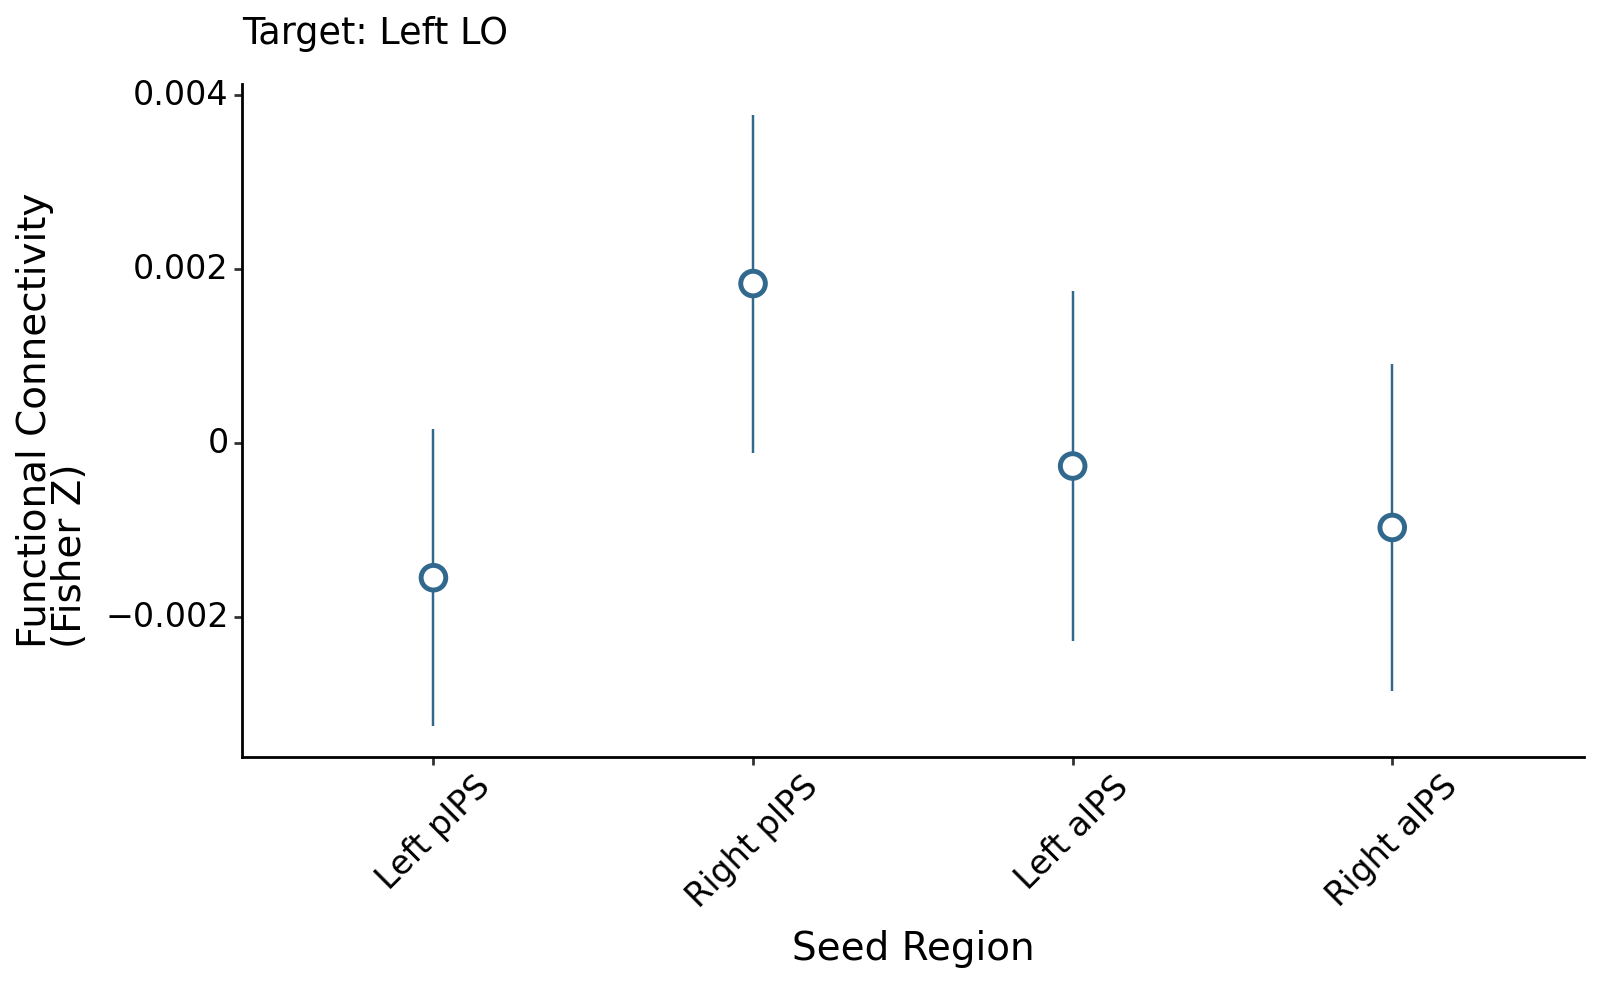



Right LO Plot:


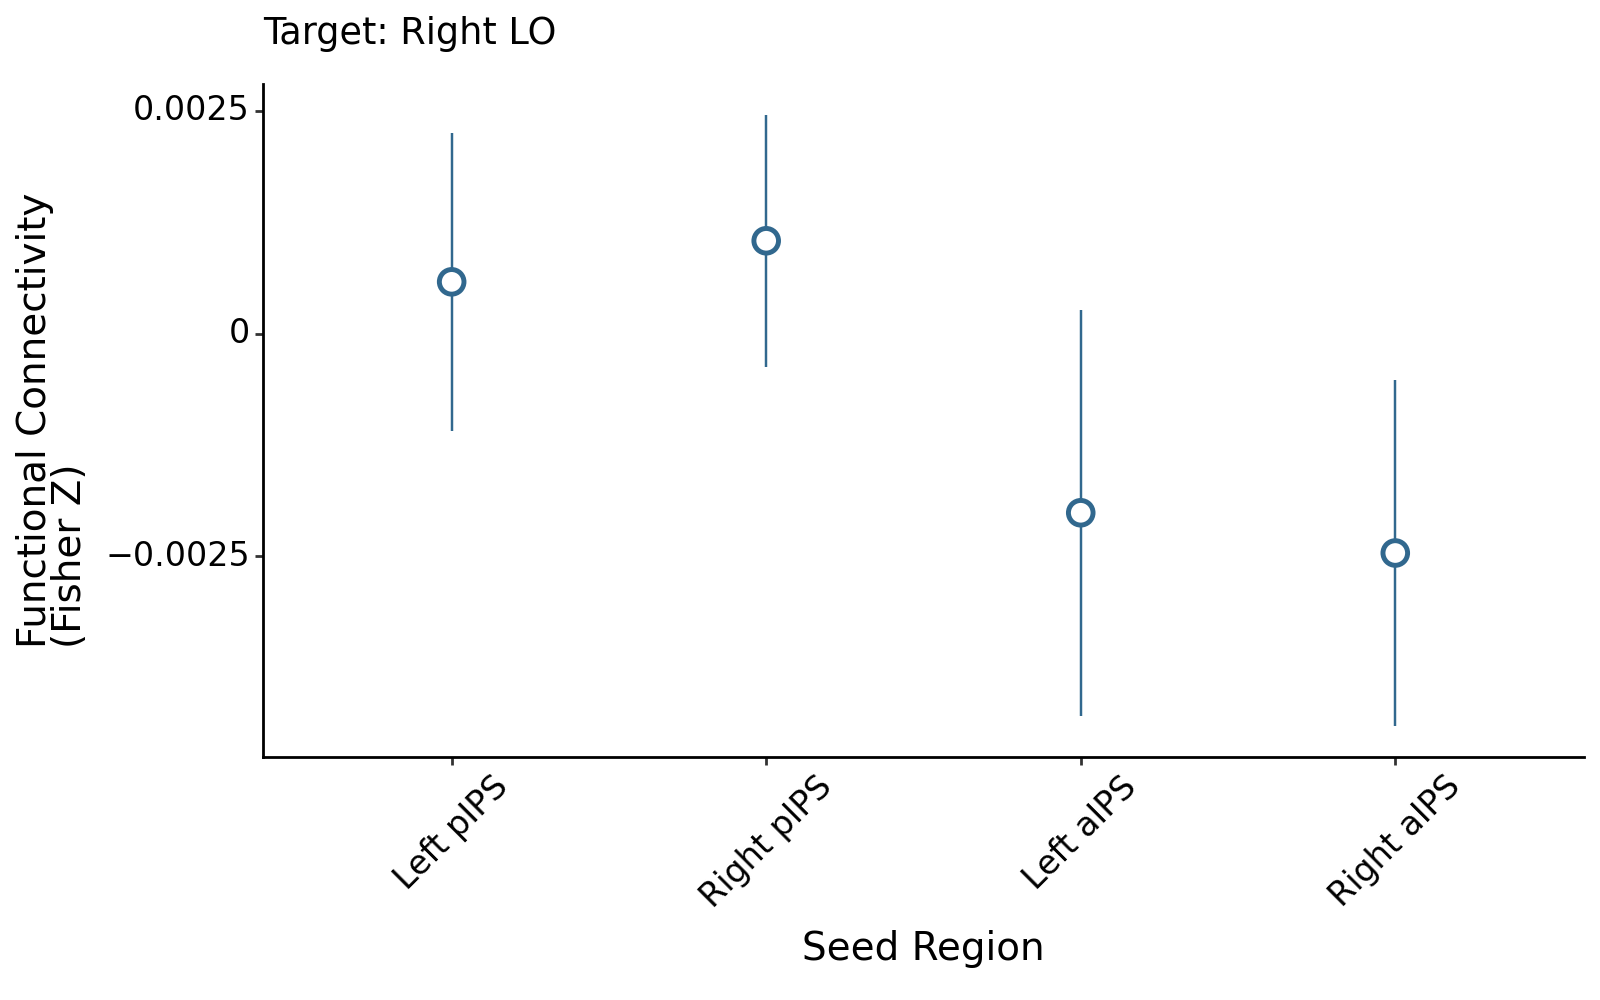

In [8]:
# plotting statistical results for PPI
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_linerange, geom_point, ylim, theme_classic, xlab, ylab, theme, element_text, element_line, element_blank, ggtitle

# Define variables
analysis = 'ppi'
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/tools'

# Read the data
df = pd.read_csv(f"{results_dir}/seed_target_activations.csv")

# Filter for the ToolLoc task and ppi analysis
df_filtered = df[(df['task'] == 'ToolLoc') & (df['analysis'] == 'ppi')]

# Create seed and target columns
df_filtered['seed'] = df_filtered['seed_hemisphere'] + '_' + df_filtered['seed_roi']
df_filtered['target'] = df_filtered['target_hemisphere'] + '_' + df_filtered['target_roi']

# Apply Fisher z-transform
df_filtered['fisher_z'] = np.arctanh(df_filtered['mean_activation'])

# Group by seed and target, calculate mean and standard error of Fisher z values
summary_df = df_filtered.groupby(['seed', 'target'])['fisher_z'].agg(['mean', 'sem']).reset_index()

# Rename columns
summary_df.columns = ['Seed', 'Target', 'FC', 'SE']

# Calculate error bar limits explicitly
summary_df['ymin'] = summary_df['FC'] - summary_df['SE']
summary_df['ymax'] = summary_df['FC'] + summary_df['SE']

# Print the data to verify calculations
print("\nData for plotting (including error bar limits):")
print(summary_df.to_string(index=False))

# Rename ROIs for better readability
seed_mapping = {
    'left_pIPS': 'Left pIPS',
    'right_pIPS': 'Right pIPS',
    'left_aIPS': 'Left aIPS',
    'right_aIPS': 'Right aIPS'
}
target_mapping = {
    'left_LO': 'Left LO',
    'right_LO': 'Right LO'
}
summary_df['Seed'] = summary_df['Seed'].map(seed_mapping)
summary_df['Target'] = summary_df['Target'].map(target_mapping)

# Set Seed as categorical with all four regions
summary_df['Seed'] = pd.Categorical(summary_df['Seed'], 
                                  categories=['Left pIPS', 'Right pIPS', 'Left aIPS', 'Right aIPS'], 
                                  ordered=False)

def create_plot(data, target):
    # Create plot with explicit error bars
    plot = (ggplot(data[data['Target'] == target])
            + geom_linerange(aes(x='Seed', ymin='ymin', ymax='ymax'), size=.5, color='#31688E')
            + geom_point(aes(x='Seed', y='FC'), shape='o', size=4, fill='white', color='#31688E', stroke=1)
            + theme_classic()
            + xlab('Seed Region')
            + ylab('Functional Connectivity\n(Fisher Z)')
            + theme(
                text=element_text(color='black'),
                axis_text_x=element_text(angle=45, size=12),  # Increased angle for better readability with more categories
                axis_text_y=element_text(size=12),
                axis_title=element_text(size=14),
                axis_line=element_line(),
                panel_border=element_blank(),
                legend_position="none",
                figure_size=(8, 5)  # Increased width to accommodate more categories
            )
            + ggtitle(f'Target: {target}'))
    return plot

# Create and print plots
print("\nLeft LO Plot:")
print(create_plot(summary_df, 'Left LO'))
print("\nRight LO Plot:")
print(create_plot(summary_df, 'Right LO'))

# Optional: Save plots to files
# left_plot = create_plot(summary_df, 'Left LO')
# right_plot = create_plot(summary_df, 'Right LO')
# left_plot.save(f"{results_dir}/left_lo_connectivity.png", dpi=300)
# right_plot.save(f"{results_dir}/right_lo_connectivity.png", dpi=300)


Left LO Plot:


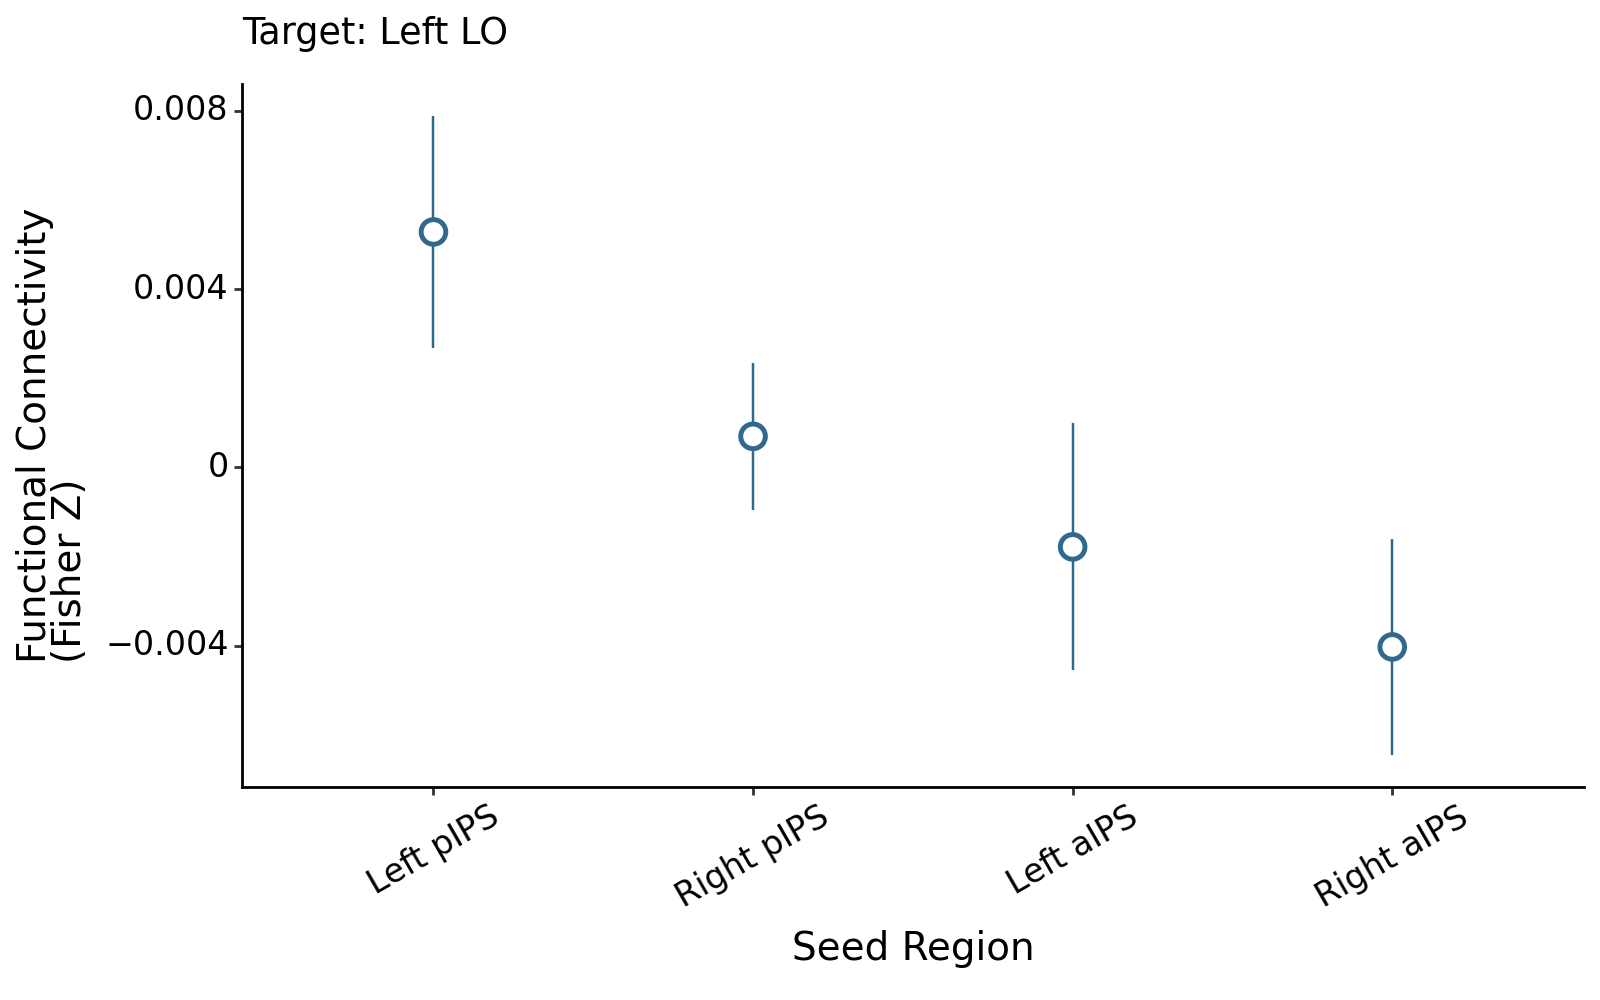



Right LO Plot:


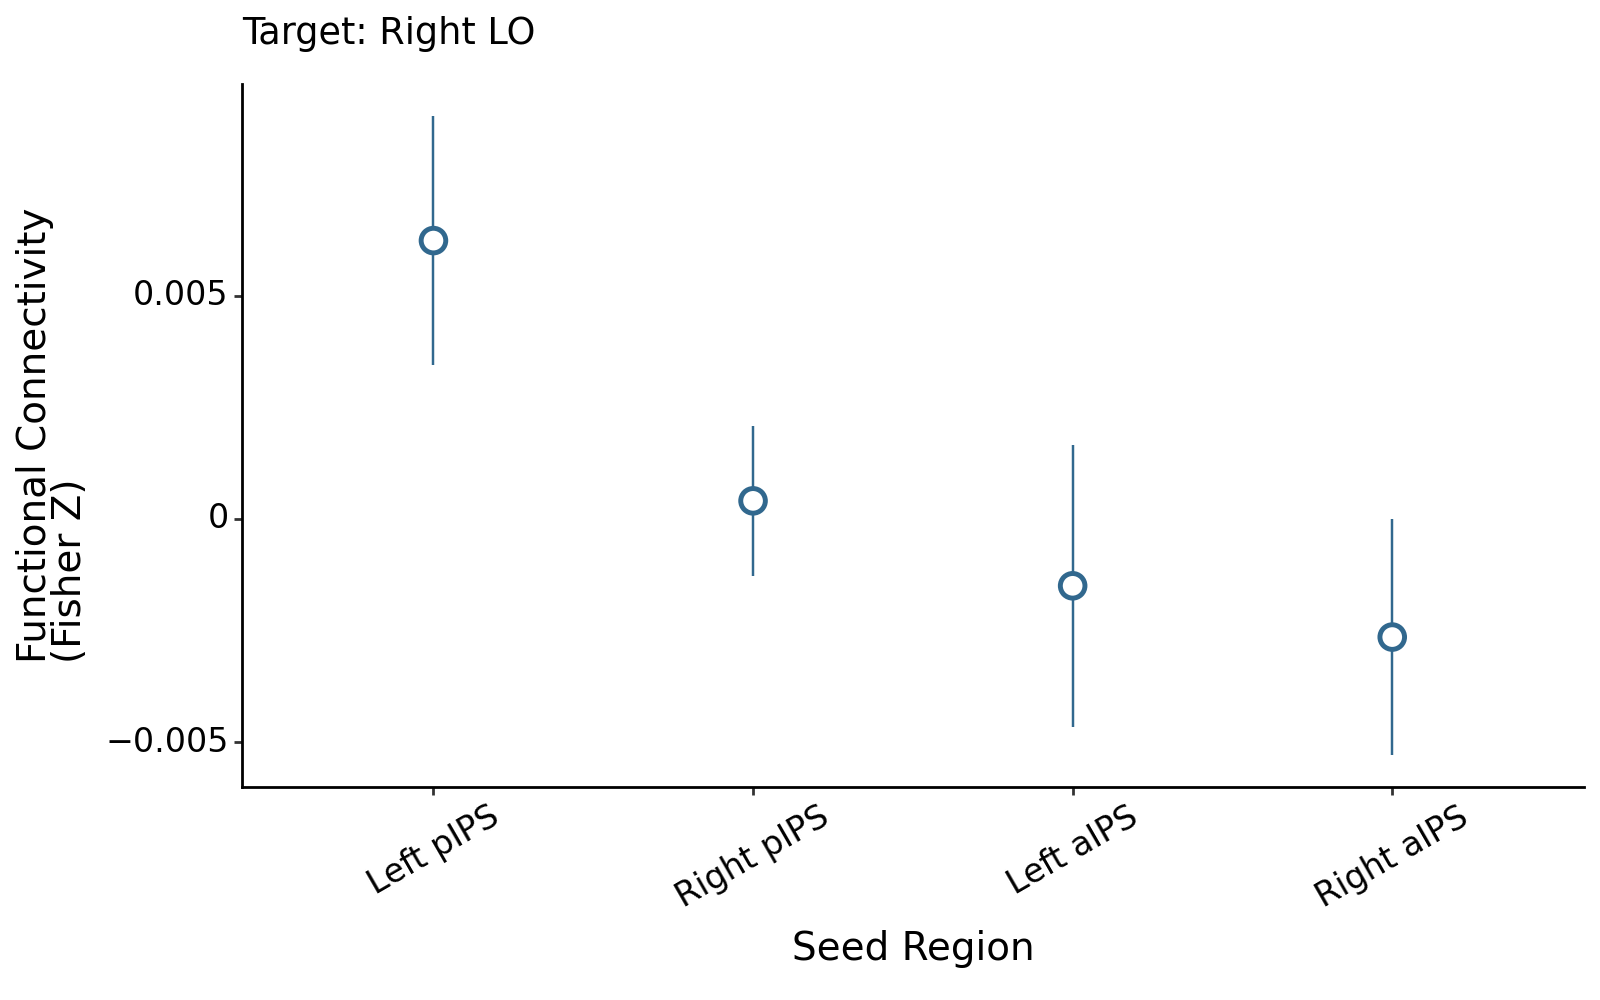

In [11]:
# DO NOT USE WITHOUT UPDATING PATHS FIRST TO OUTPUT SUMMARY OF FC_PPI.PY
# add aIPS to the plots || plots full LO parcel average
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_linerange, geom_point, ylim, theme_classic, xlab, ylab, theme, element_text, element_line, element_blank, ggtitle

# Define variables
analysis = 'ppi'
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/tools'

# Read the data
df = pd.read_csv(f"{results_dir}/parcel_seed_target_activations.csv")

# Filter for the ToolLoc task and ppi analysis
df_filtered = df[(df['task'] == 'ToolLoc') & (df['analysis'] == 'ppi')]

# Create seed and target columns
df_filtered['seed'] = df_filtered['seed_hemisphere'] + '_' + df_filtered['seed_roi']
df_filtered['target'] = df_filtered['target_hemisphere'] + '_' + df_filtered['target_roi']

# Apply Fisher z-transform
df_filtered['fisher_z'] = np.arctanh(df_filtered['mean_activation'])

# Group by seed and target, calculate mean and standard error of Fisher z values
summary_df = df_filtered.groupby(['seed', 'target'])['fisher_z'].agg(['mean', 'sem']).reset_index()

# Rename columns
summary_df.columns = ['Seed', 'Target', 'FC', 'SE']

# Calculate error bar limits explicitly
summary_df['ymin'] = summary_df['FC'] - summary_df['SE']
summary_df['ymax'] = summary_df['FC'] + summary_df['SE']

# Updated seed mapping to include aIPS
seed_mapping = {
    'left_pIPS': 'Left pIPS',
    'right_pIPS': 'Right pIPS',
    'left_aIPS': 'Left aIPS',
    'right_aIPS': 'Right aIPS'
}
target_mapping = {
    'left_LO': 'Left LO',
    'right_LO': 'Right LO'
}
summary_df['Seed'] = summary_df['Seed'].map(seed_mapping)
summary_df['Target'] = summary_df['Target'].map(target_mapping)

# Set Seed as categorical with updated order
summary_df['Seed'] = pd.Categorical(summary_df['Seed'], 
                                  categories=['Left pIPS', 'Right pIPS', 'Left aIPS', 'Right aIPS'], 
                                  ordered=False)

def create_plot(data, target):
    # Create plot with explicit error bars
    plot = (ggplot(data[data['Target'] == target])
            + geom_linerange(aes(x='Seed', ymin='ymin', ymax='ymax'), size=.5, color='#31688E')
            + geom_point(aes(x='Seed', y='FC'), shape='o', size=4, fill='white', color='#31688E', stroke=1)
            + theme_classic()
            + xlab('Seed Region')
            + ylab('Functional Connectivity\n(Fisher Z)')
            + theme(
                text=element_text(color='black'),
                axis_text_x=element_text(angle=30, size=12),
                axis_text_y=element_text(size=12),
                axis_title=element_text(size=14),
                axis_line=element_line(),
                panel_border=element_blank(),
                legend_position="none",
                figure_size=(8, 5)  # Increased width to accommodate more seed regions
            )
            + ggtitle(f'Target: {target}'))
    return plot

# Create and print plots
print("\nLeft LO Plot:")
print(create_plot(summary_df, 'Left LO'))
print("\nRight LO Plot:")
print(create_plot(summary_df, 'Right LO'))